# ETL notebook

Download additional python packages

In [1]:
!pip install opencv-python

     |████████████████████████████████| 28.7MB 12.4MB/s eta 0:00:01


Install libraries

In [1]:
# Importing standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle

import types
from botocore.client import Config
import ibm_boto3
import csv
from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt
from math import sqrt, ceil
import random

Define credentials to access a IBM cloud bucket storage

In [2]:
# The code was removed by Watson Studio for sharing.

We define a function to read rgb data from a pickle file provided by the customer

In [3]:
# Defining function for loading dataset from 'pickle' file
def load_rgb_data(file):
    # Opening 'pickle' file and getting images
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3
        # At the same time method 'astype()' used for converting ndarray from int to float
        # It is needed to divide float by float when applying Normalization
        x = d['features'].astype(np.float32)   # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        y = d['labels']                        # 1D numpy.ndarray type, for train = (34799,)
        s = d['sizes']                         # 2D numpy.ndarray type, for train = (34799, 2)
        c = d['coords']                        # 2D numpy.ndarray type, for train = (34799, 4)
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """

    # Returning ready data
    return x, y, s, c

The customer has provided a separate csv file with the description of every class (traffic sign description). We define a function to obtain the description of each class

In [4]:
# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []

    # Opening 'csv' file and getting image's labels
    with open(file, 'r') as f:
        reader = csv.reader(f)
        # Going through all rows
        for row in reader:
            # Adding from every row second column with name of the label
            label_list.append(row[1])
        # Deleting the first element of list because it is the name of the column
        del label_list[0]
    # Returning resulted list
    return label_list

The customer has provided 3 separate sets for training, validation and testing. We load into a dictionary of numpy arrays.

In [6]:
cos.download_file(Bucket=credentials['BUCKET'], Key='train.pickle', Filename='train.pickle')   
cos.download_file(Bucket=credentials['BUCKET'], Key='valid.pickle', Filename='valid.pickle')
cos.download_file(Bucket=credentials['BUCKET'], Key='test.pickle', Filename='test.pickle')
cos.download_file(Bucket=credentials['BUCKET'], Key='label_names.csv', Filename='label_names.csv')

# Loading rgb data from training dataset
x_train, y_train, s_train, c_train = load_rgb_data('train.pickle')
#
# # Loading rgb data from validation dataset
x_validation, y_validation, s_validation, c_validation = load_rgb_data('valid.pickle')
#
# # Loading rgb data from test dataset
x_test, y_test, s_test, c_test = load_rgb_data('test.pickle')

# # Getting texts for every class
label_list = label_text('label_names.csv')

We define a function to make a grid of the 9 x 9 with samples of training (, validation and testing data

In [7]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
   
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                #grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid

We visualize a random set of 81 pictures of training, validation and testing data

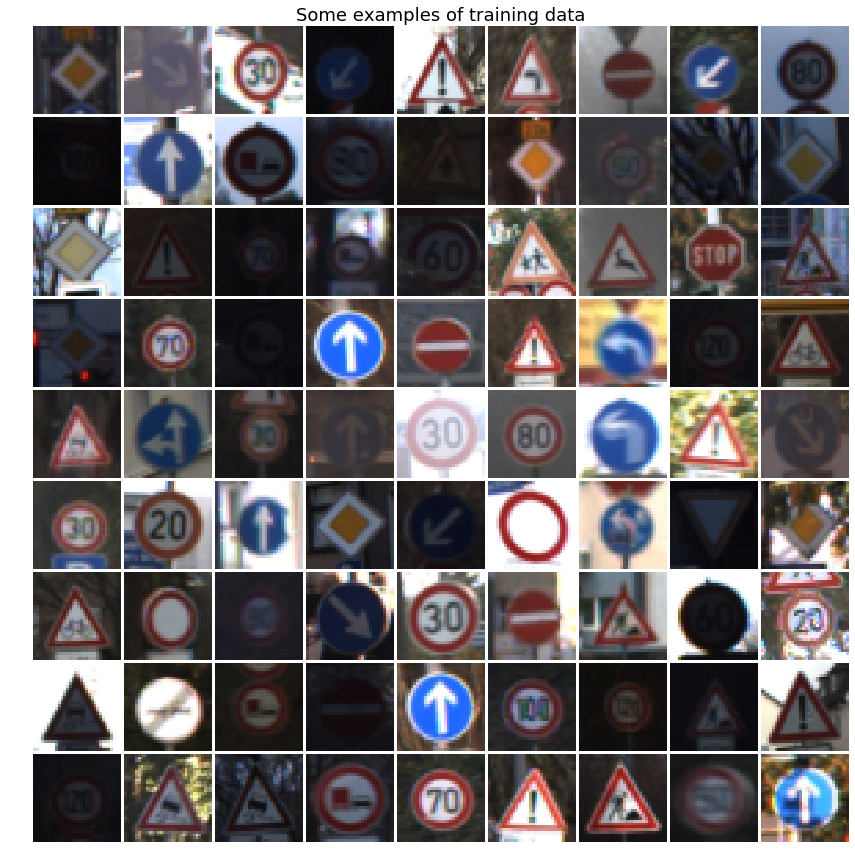

In [8]:
# Visualizing some examples of training data
examples = np.zeros((81, x_train.shape[1], x_train.shape[2], x_train.shape[3]))

for i in range(81):  
    examples[i] = x_train[int(np.size(x_train,0)*random.random()), :, :, :]
    
# Plotting
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)
plt.show()
plt.close()

# Saving plot
fig.savefig('training_examples.png')
plt.close()

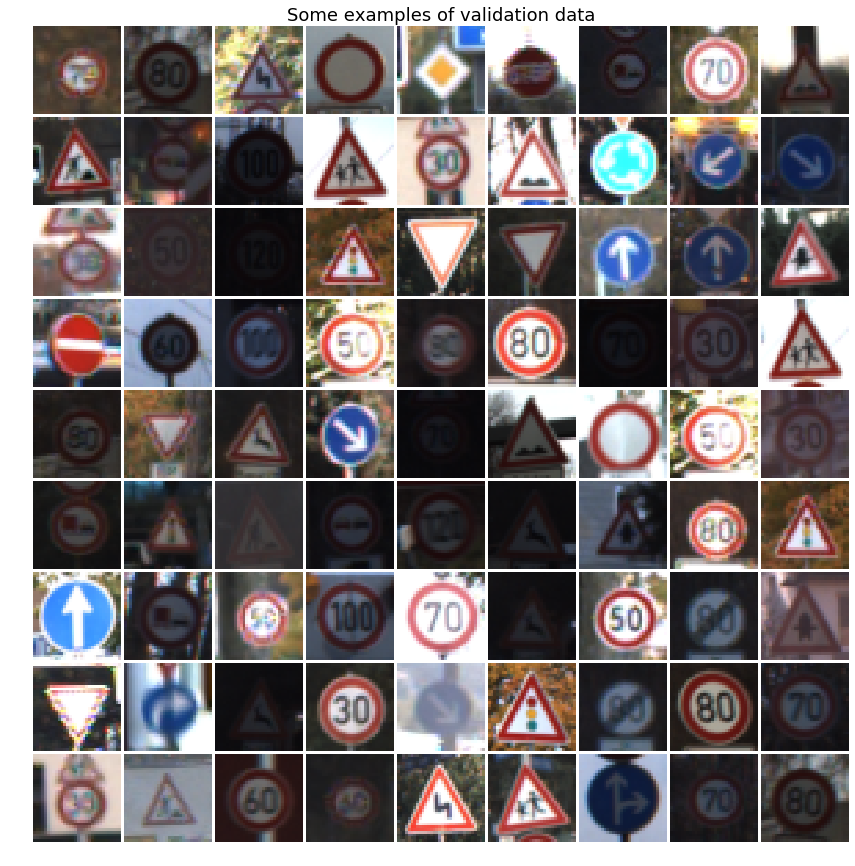

In [9]:
# Visualizing some examples of validation data
examples = np.zeros((81, x_validation.shape[1], x_validation.shape[2], x_validation.shape[3]))

for i in range(81):  
    examples[i] = x_validation[int(np.size(x_validation,0)*random.random()), :, :, :]

# Plotting
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of validation data', fontsize=18)
plt.show()
plt.close()

# Saving plot
fig.savefig('validation_examples.png')
plt.close()

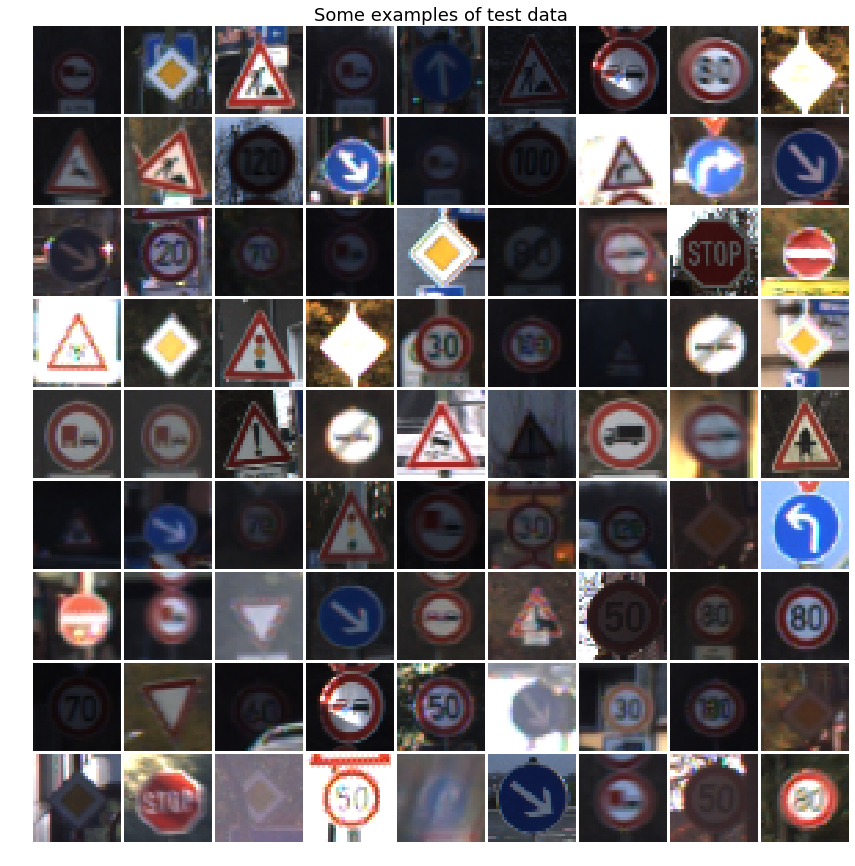

In [10]:
# Visualizing some examples of test data
examples = np.zeros((81, x_test.shape[1], x_test.shape[2], x_test.shape[3]))

for i in range(81):  
    examples[i] = x_test[int(np.size(x_test,0)*random.random()), :, :, :]

# Plotting
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of test data', fontsize=18)
plt.show()
plt.close()

# Saving plot
fig.savefig('test_examples.png')
plt.close()

We define a different set of functions for data augmentation

In [5]:
# Defining function for equalization training dataset
def equalize_training_dataset(x_train, y_train):
    # Getting number of examples for every label
    number_of_examples_for_every_label = np.bincount(y_train)
    # Calculating total amount of unique labels
    number_of_labels = np.arange(len(number_of_examples_for_every_label))

    # Iterating over all number of labels
    # Showing progress ber with 'tqdm'
    for i in tqdm(number_of_labels):
        # Calculating how many examples is needed to add for current label
        # 'np.mean(number_of_examples_for_every_label)' - average number over examples for every label
        number_of_examples_to_add = int(np.mean(number_of_examples_for_every_label) * 2.5) - \
                                    number_of_examples_for_every_label[i]

        # Defining temporary arrays for collecting new images
        x_temp = []
        y_temp = []

        # Getting random image from current label
        # Transforming it and adding to the temporary arrays
        for j in range(number_of_examples_to_add):
            getting_random_image = random_image(x_train, y_train, i)
            x_temp.append(transformation_brightness_rotation(getting_random_image))
            y_temp.append(i)

        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)

    return x_train, y_train

# Defining function for getting random image of one label
def random_image(x_train, y_train, y_number):
    # Getting indexes of needed 'y_number' from 'y_train'
    # Defining True - False array
    image_indexes = np.where(y_train == y_number)
    # Getting random index of needed label
    # 'np.bincount(y_train)' - array with number of examples for every label
    # 'np.bincount(y_train)[y_number] - 1' - number of examples for 'y_number' label
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    # Returning random image from 'x_train'
    # 'x_train[image_indexes]' - returns array with only 'y_number' label
    # 'x_train[image_indexes][random_index]' - random image of needed label
    return x_train[image_indexes][random_index]

# Defining function for transformation: brightness + rotation
def transformation_brightness_rotation(image):
    return brightness_changing(rotation_changing(image))

# Defining function for changing brightness
def brightness_changing(image):
    # Converting firstly image from RGB to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Defining random value for changing brightness
    random_brightness = 0.25 + np.random.uniform()
    # Implementing changing of Value channel of HSV image
    image_hsv[:, :, 2] = image_hsv[:, :, 2] * random_brightness
    # Converting HSV changed image to RGB
    image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    # Returning image with changed brightness
    return image_rgb

# Defining function for changing rotation of image
def rotation_changing(image):
    # Defining angle range
    angle_range = 25
    # Defining angle rotation
    angle_rotation = np.random.uniform(angle_range) - angle_range / 2
    # Getting shape of image
    rows, columns, channels = image.shape
    # Implementing rotation
    # Calculating Affine Matrix
    affine_matrix = cv2.getRotationMatrix2D((columns / 2, rows / 2), angle_rotation, 1)
    # Warping original image with Affine Matrix
    rotated_image = cv2.warpAffine(image, affine_matrix, (columns, rows))
    # Returning rotated image
    return rotated_image

# Defining function for Local Histogram Equalization
def local_histogram_equalization(image):
    # Creating CLAHE object with arguments
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))

    # Applying Local Histogram Equalization and returning resulted image
    return clahe.apply(image)

# Defining function for preprocessing loaded data
def preprocess_data(d, shuffle=False, lhe=False, norm_255=False, mean_norm=False, std_norm=False,
                    transpose=True, colour='rgb'):
    # Applying Shuffling
    if shuffle:
        # Shuffle data
        # Multi-dimensional arrays are only shuffled along the first axis
        # By using seed we generate two times the same random numbers
        # And save appropriate connection: image --> label
        np.random.seed(0)
        np.random.shuffle(d['x_train'])
        np.random.seed(0)
        np.random.shuffle(d['y_train'])
        np.random.seed(0)
        np.random.shuffle(d['x_validation'])
        np.random.seed(0)
        np.random.shuffle(d['y_validation'])
        np.random.seed(0)
        np.random.shuffle(d['x_test'])
        np.random.seed(0)
        np.random.shuffle(d['y_test'])
        # Also, possible to do like following:
        # x_train, y_train = shuffle(x_train, y_train)
        # This function is from sklearn library:
        # from sklearn.utils import shuffle

    # Applying Local Histogram Equalization
    if lhe:
        # Function map applies first argument to all elements of the second argument
        # First argument in our case is a function
        # Second argument in our case is np array
        # We need to slice it in order to pass into the function only (32, 32) and not (1, 32, 32)
        # Also, map functions applies to first argument all images of the second argument
        # In our case it is a number of d['x_train'].shape[0]
        # Result we wrap with list and then list convert to np.array
        # And reshaping it to make it again 4D tensor

        d['x_train'] = list(map(local_histogram_equalization, d['x_train'][:, 0, :, :].astype(np.uint8)))
        d['x_train'] = np.array(d['x_train'])
        d['x_train'] = d['x_train'].reshape(d['x_train'].shape[0], 1, 32, 32)
        d['x_train'] = d['x_train'].astype(np.float32)
        d['x_validation'] = list(map(local_histogram_equalization, d['x_validation'][:, 0, :, :].astype(np.uint8)))
        d['x_validation'] = np.array(d['x_validation'])
        d['x_validation'] = d['x_validation'].reshape(d['x_validation'].shape[0], 1, 32, 32)
        d['x_validation'] = d['x_validation'].astype(np.float32)
        d['x_test'] = list(map(local_histogram_equalization, d['x_test'][:, 0, :, :].astype(np.uint8)))
        d['x_test'] = np.array(d['x_test'])
        d['x_test'] = d['x_test'].reshape(d['x_test'].shape[0], 1, 32, 32)
        d['x_test'] = d['x_test'].astype(np.float32)

    # Applying /255.0 Normalization
    if norm_255:
        # Normalizing whole data by dividing /255.0
        d['x_train'] = d['x_train'].astype(np.float32) / 255.0
        d['x_validation'] /= 255.0
        d['x_test'] /= 255.0

        # Preparing 'mean image'
        # Subtracting the dataset by 'mean image' serves to center the data
        # It helps for each feature to have a similar range and gradients don't go out of control.
        # Calculating 'mean image' from training dataset along the rows by specifying 'axis=0'
        # We CALCULATE 'mean image' ONLY FROM TRAINING dataset
        # Calculating mean image from training dataset along the rows by specifying 'axis=0'
        mean_image = np.mean(d['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)
        # Saving calculated 'mean_image' into 'pickle' file
        # We will use it when preprocess input data for classifying
        # We will need to subtract input image for classifying
        # As we're doing now for training, validation and testing data
        dictionary = {'mean_image_' + colour: mean_image}
        
        cos.download_file(Bucket=credentials['BUCKET'], Key='mean_image_' + colour + '.pickle', Filename='mean_image_' + colour + '.pickle')
        with open('mean_image_' + colour + '.pickle', 'wb') as f_mean_image:
            pickle.dump(dictionary, f_mean_image)

        # Preparing 'std image'
        # Calculating standard deviation from training dataset along the rows by specifying 'axis=0'
        std = np.std(d['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)
        # Saving calculated 'std' into 'pickle' file
        # We will use it when preprocess input data for classifying
        # We will need to divide input image for classifying
        # As we're doing now for training, validation and testing data
        dictionary = {'std_' + colour: std}
        
        cos.download_file(Bucket=credentials['BUCKET'], Key='std_' + colour + '.pickle', Filename='std_' + colour + '.pickle')
        with open('std_' + colour + '.pickle', 'wb') as f_std:
            pickle.dump(dictionary, f_std)

    # Applying Mean Normalization
    if mean_norm:
        # Normalizing data by subtracting with 'mean image'
        # Getting saved data for 'mean image'
        # Opening file for reading in binary mode
        with open('mean_image_' + colour + '.pickle', 'rb') as f:
            mean_image = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

        d['x_train'] -= mean_image['mean_image_' + colour]
        d['x_validation'] -= mean_image['mean_image_' + colour]
        d['x_test'] -= mean_image['mean_image_' + colour]

    # Applying STD Normalization
    if std_norm:
        # Normalizing data by dividing with 'standard deviation'
        # Getting saved data for 'std image'
        # Opening file for reading in binary mode
        with open('std_' + colour + '.pickle', 'rb') as f:
            std = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

        # Don't forget to change names for mean and std files when preprocessing for grayscale purposes
        d['x_train'] /= std['std_' + colour]
        d['x_validation'] /= std['std_' + colour]
        d['x_test'] /= std['std_' + colour]

    # WARNING!
    # Do not make transpose starting from data1
    # As data0 was already transposed
    if transpose:
        # Transposing every dataset to make channels come first
        d['x_train'] = d['x_train'].transpose(0, 3, 1, 2)  # (86989, 3, 32, 32)
        d['x_validation'] = d['x_validation'].transpose(0, 3, 1, 2)  # (86989, 3, 32, 32)
        d['x_test'] = d['x_test'].transpose(0, 3, 1, 2)  # (86989, 3, 32, 32)

    # Returning preprocessed data
    return d

In [12]:
# # Implementing equalization of training dataset
x_train, y_train = equalize_training_dataset(x_train.astype(np.uint8), y_train)

# # Putting loaded and equalized data into the dictionary
# # Equalization is done only for training dataset
d_loaded = {'x_train': x_train, 'y_train': y_train,
            'x_validation': x_validation, 'y_validation': y_validation,
            'x_test': x_test, 'y_test': y_test,
            'labels': label_list}

# # Applying preprocessing
data0 = preprocess_data(d_loaded, shuffle=True, transpose=True)
print('Before Backward Calculation')
print(data0['x_train'][0, 0, :, 0])

# Saving loaded and preprocessed data into 'pickle' file

with open('data_shuffled.pickle', 'wb') as f:
    pickle.dump(data0, f)
    # Releasing memory
del data0

# upload feather object
cos.upload_file(Filename='data_shuffled.pickle', Bucket=credentials['BUCKET'], Key='data_shuffled.pickle') 

100%|██████████| 43/43 [01:16<00:00,  2.02s/it]


Before Backward Calculation
[ 4 20 21 23 23 24 25 25 26 26 27 28 28 28 28 28 29 28 27 26 24 23 21 21
 19 16 15 13 12 11 10  8]


In [1]:
cos.download_file(Bucket=credentials['BUCKET'], Key='data_shuffled.pickle', Filename='data_shuffled.pickle')   

with open('data_shuffled.pickle', 'rb') as f:
     d_0_1 = pickle.load(f, encoding='latin1')  # dictionary type
        
# Preprocessing data0 --> data1
data1 = preprocess_data(d_0_1, shuffle=False, norm_255=True, transpose=False, colour='rgb')
# Saving loaded and preprocessed data into 'pickle' file
with open('data_shuffled_norm255.pickle', 'wb') as f:
    pickle.dump(data1, f)
# Releasing memory
del d_0_1
del data1

# upload feather object
cos.upload_file(Filename='data_shuffled_norm255.pickle', Bucket=credentials['BUCKET'], Key='data_shuffled_norm255.pickle') 

NameError: name 'cos' is not defined

In [9]:
cos.download_file(Bucket=credentials['BUCKET'], Key='data_shuffled.pickle', Filename='data_shuffled.pickle')   
 
with open('data_shuffled.pickle', 'rb') as f:
    d_0_2 = pickle.load(f, encoding='latin1')  # dictionary type
# Preprocessing data0 --> data2
data2 = preprocess_data(d_0_2, shuffle=False, norm_255=True, mean_norm=True, transpose=False, colour='rgb')
# Saving loaded and preprocessed data into 'pickle' file
with open('data_shuffled_norm255_meanNorm.pickle', 'wb') as f:
    pickle.dump(data2, f)
# Releasing memory
del d_0_2
del data2

# upload feather object
cos.upload_file(Filename='data_shuffled_norm255_meanNorm.pickle', Bucket=credentials['BUCKET'], Key='data_shuffled_norm255_meanNorm.pickle') 

In [6]:
cos.download_file(Bucket=credentials['BUCKET'], Key='data_shuffled.pickle', Filename='data_shuffled.pickle')   
 
with open('data_shuffled.pickle', 'rb') as f:
    d_0_2 = pickle.load(f, encoding='latin1')  # dictionary type
# Preprocessing data0 --> data2
data2 = preprocess_data(d_0_2, shuffle=False, norm_255=True, mean_norm=True, std_norm=True, transpose=False, colour='rgb')
# Saving loaded and preprocessed data into 'pickle' file
with open('data_shuffled_norm255_meanStdNorm.pickle', 'wb') as f:
    pickle.dump(data2, f)
# Releasing memory
del d_0_2
del data2

# upload feather object
cos.upload_file(Filename='data_shuffled_norm255_meanStdNorm.pickle', Bucket=credentials['BUCKET'], Key='data_shuffled_norm255_meanStdNorm.pickle')